# Identify patients diagnosed with Type 2 Diabetes

In the first phase of this prediction challenge Practice Fusion invited anyone with an interest in using electronic medical record data to improve public health to submit and vote on ideas for prediction problems based on a new dataset of 10,000 de-identified medical records. The votes are in and Shea Parkes' top voted submission has won.

Practice Fusion is now sponsoring the second and final phase of the challenge inspired by the winning problem: Identify patients diagnosed with Type 2 Diabetes Mellitus.

Over 25 million people, or nearly 8.3% of the entire United States population, have diabetes. Diabetes is also associated with a wide range of complications from heart disease and stroke to blindness and kidney disease. Predicting who has diabetes will lead to a better understanding of these complications and the common comorbidities that diabetics suffer.

The Challenge: Given a de-identified data set of patient electronic health records, build a model to determine who has a diabetes diagnosis, as defined by ICD9 codes 250, 250.0, 250.*0 or 250.*2 (e.g., 250, 250.0, 250.00, 250.10, 250.52, etc).
    
[Challenge Link](https://www.kaggle.com/c/pf2012-diabetes)

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#for table-like data and matrices
import numpy as np
import pandas as pd

#Visualisations
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

#Configure Visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):

    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels    
    

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [3]:
train  = pd.read_csv("./input/train.csv")
test   = pd.read_csv("./input/test.csv")
frames = [train, test]
indata = pd.concat(frames)

In [4]:
print(indata.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9947 entries, 0 to 992
Data columns (total 27 columns):
code280289    9947 non-null int64
sBP           9947 non-null int64
code240279    9947 non-null int64
weight        9947 non-null int64
code780799    9947 non-null int64
code360389    9947 non-null int64
height        9947 non-null int64
code680709    9947 non-null int64
dBP           9947 non-null int64
code320359    9947 non-null int64
BMI           9947 non-null int64
state         9947 non-null object
code740759    9947 non-null int64
code001139    9947 non-null int64
code460519    9947 non-null int64
code520579    9947 non-null int64
code710739    9947 non-null int64
code760779    9947 non-null int64
code800999    9947 non-null int64
code390459    9947 non-null int64
diabetes      9947 non-null int64
code290319    9947 non-null int64
gender        9947 non-null object
age           9947 non-null int64
code630679    9947 non-null int64
code580629    9947 non-null int64
code1402

In [40]:
print('# of rows', len(indata))
print('# of columns', len(indata.columns))
pd.set_option('display.max_columns', 27)
# pd.set_option('display.max_rows', 9948)
indata.head()
# pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

# of rows 9552
# of columns 27


In [9]:
indata.describe()

,code280289,sBP,code240279,weight,code780799,code360389,height,code680709,dBP,code320359,BMI,code740759,code001139,code460519,code520579,code710739,code760779,code800999,code390459,diabetes,code290319,age,code630679,code580629,code140239
count,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.00000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000,9947.000000
mean,0.095205,124.938675,0.606012,175.304112,0.568915,0.210616,65.76988,0.238162,75.311149,0.205791,32.225797,0.017895,0.206494,0.522972,0.326933,0.506082,0.001005,0.154318,0.532924,0.191414,0.382829,52.585202,0.010656,0.319192,0.079521
std,0.293512,17.259632,0.488657,44.214842,0.495253,0.407767,4.72825,0.425980,11.055824,0.404299,115.348996,0.132576,0.404810,0.499497,0.469116,0.499988,0.031693,0.361271,0.498940,0.393434,0.486102,17.535396,0.102684,0.466187,0.270565
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000
25%,0.000000,115.000000,0.000000,140.000000,0.000000,0.000000,63.00000,0.000000,70.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000
50%,0.000000,125.000000,1.000000,170.000000,1.000000,0.000000,66.00000,0.000000,75.000000,0.000000,28.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,0.000000
75%,0.000000,135.000000,1.000000,200.000000,1.000000,0.000000,69.00000,0.000000,80.000000,0.000000,32.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,65.000000,0.000000,1.000000,0.000000
max,1.000000,220.000000,1.000000,590.000000,1.000000,1.000000,112.00000,1.000000,145.000000,1.000000,4629.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000,1.000000,1.000000,1.000000


In [11]:
#Checking for missing data
print('# of missing data', indata.isnull().any().sum())

# of missing data 0


In [12]:
describe_more(indata)

,Datatype,Levels,Variable
0,int64,2,code280289
24,int64,2,code630679
22,object,2,gender
21,int64,2,code290319
20,int64,2,diabetes
19,int64,2,code390459
18,int64,2,code800999
17,int64,2,code760779
16,int64,2,code710739
15,int64,2,code520579


In [13]:
#change objects to numeric values
from sklearn import preprocessing

for f in indata.columns:
    if indata[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(np.unique(list(indata[f].values)))
        indata[f] = lbl.transform(list(indata[f].values))

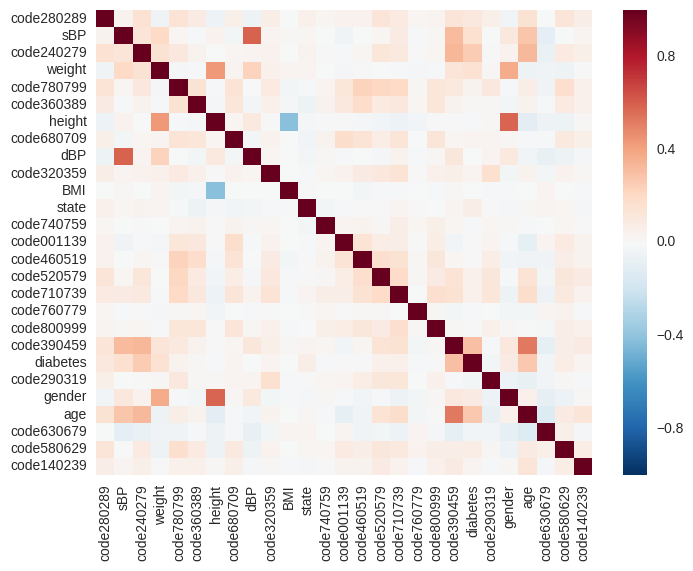

In [14]:
sns.heatmap(indata.corr())

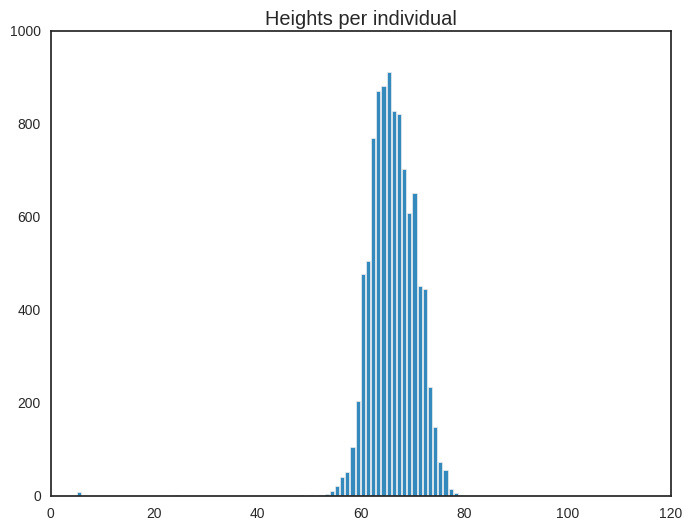

In [15]:
count = indata.groupby('height').height.count()

values = count.values
indx   = count.index
# print(indx)
# print(values)
# print(sum(values))

mean = sum(values)/len(indx)
variance = np.sqrt(sum((values-mean)**2)/len(indx))

plt.bar(indx, values)
plt.title('Heights per individual')
plt.xticks(rotation='horizontal')
plt.show()

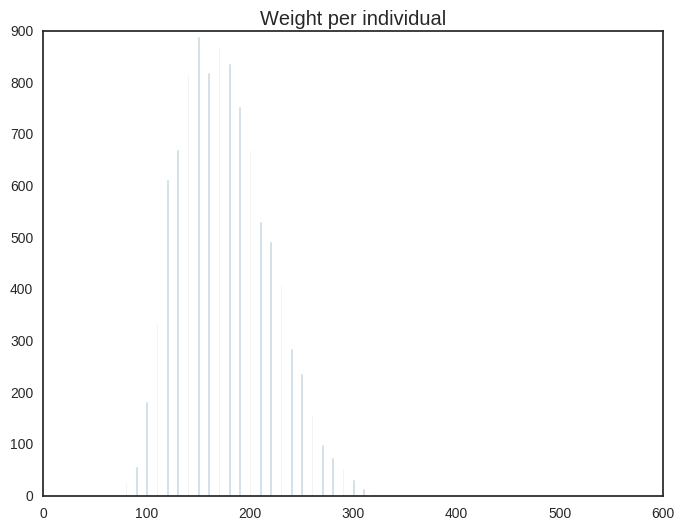

In [16]:
count = indata.groupby('weight').weight.count()

values = count.values
indx   = count.index

mean = sum(values)/len(indx)
variance = np.sqrt(sum((values-mean)**2)/len(indx))

plt.bar(indx, values)
plt.title('Weight per individual')
plt.xticks(rotation='horizontal')
plt.show()

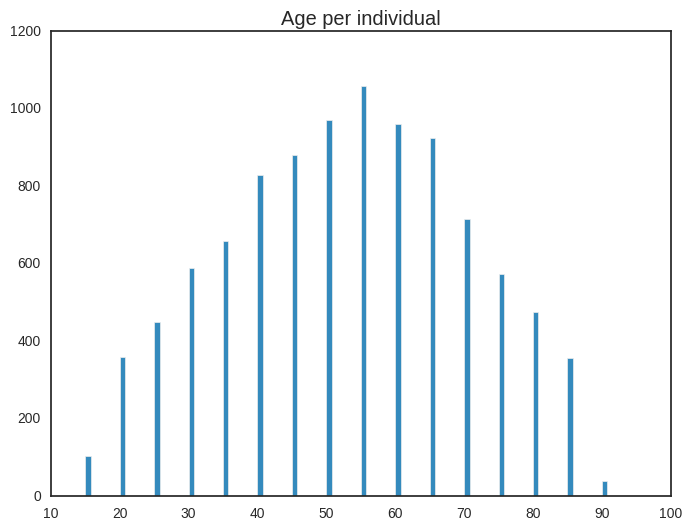

In [17]:
count = indata.groupby('age').age.count()

values = count.values
indx   = count.index
# print(indx)
# print(values)
# print(sum(values))

mean = sum(values)/len(indx)
variance = np.sqrt(sum((values-mean)**2)/len(indx))

plt.bar(indx, values)
plt.title('Age per individual')
plt.xticks(rotation='horizontal')
plt.show()

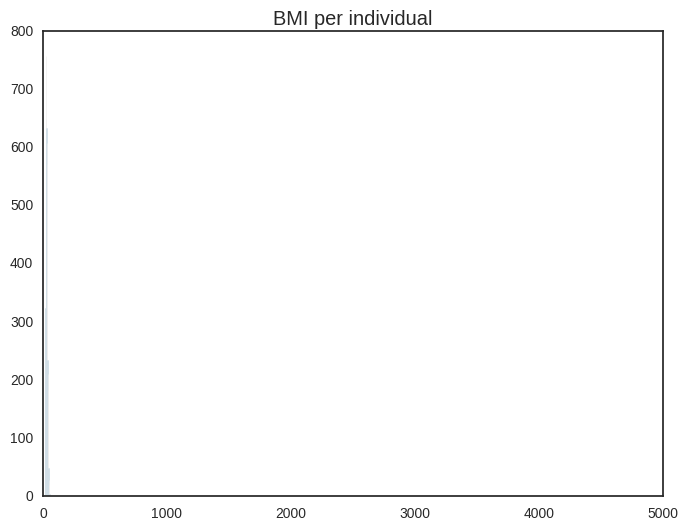

In [18]:
count = indata.groupby('BMI').BMI.count()

values = count.values
indx   = count.index

mean = sum(values)/len(indx)
variance = np.sqrt(sum((values-mean)**2)/len(indx))

plt.bar(indx, values)
plt.title('BMI per individual')
plt.xticks(rotation='horizontal')
plt.show()

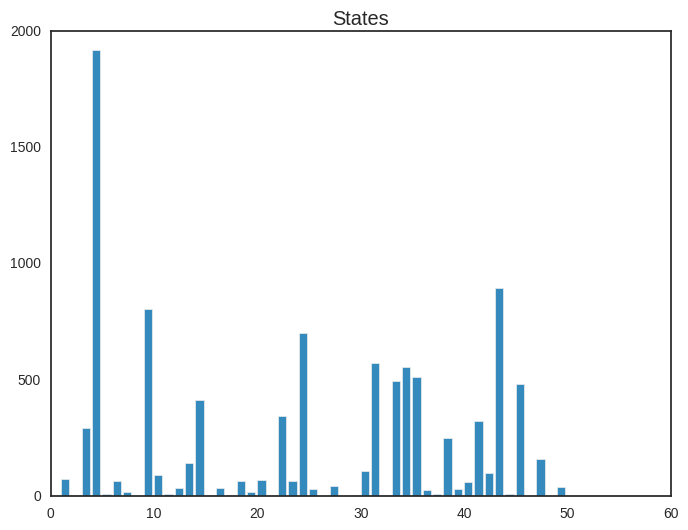

In [19]:
count = indata.groupby('state').state.count()

values = count.values
indx   = count.index

mean = sum(values)/len(indx)
variance = np.sqrt(sum((values-mean)**2)/len(indx))

plt.bar(indx, values)
plt.title('States')
plt.xticks(rotation='horizontal')
plt.show()

In [20]:
#filter bad values
print(indata.min())
# print(indata.max())
# print(indata.idxmin())
# print(indata.idxmax())

code280289     0
sBP           10
code240279     0
weight         0
code780799     0
code360389     0
height         5
code680709     0
dBP            0
code320359     0
BMI            0
state          0
code740759     0
code001139     0
code460519     0
code520579     0
code710739     0
code760779     0
code800999     0
code390459     0
diabetes       0
code290319     0
gender         0
age           15
code630679     0
code580629     0
code140239     0
dtype: int64


In [20]:
r_indx = 14
print("height", indata.iloc[r_indx,6])
print("weight", indata.iloc[r_indx,3])
print("BMI", indata.iloc[r_indx,10])
print("age", indata.iloc[r_indx,23])

height 5
weight 110
BMI 3166
age 55


In [21]:
r_indx = 3502
print("height", indata.iloc[r_indx,6])
print("weight", indata.iloc[r_indx,3])
print("BMI", indata.iloc[r_indx,10])
print("age", indata.iloc[r_indx,23])

height 67
weight 0
BMI 1
age 55


Having determined that their are outliers in data, going to do data trimming - based on age, weight and height columns --- as such analysis should only be valid for individuals whose stats lie in this range

In [21]:
#To check for outlier points

low = .002
high = .998
qdf = indata.quantile([low, high])

print(qdf.loc[low,'age'])
qdf

15.0


,code280289,sBP,code240279,weight,code780799,code360389,height,code680709,dBP,code320359,BMI,state,code740759,code001139,code460519,code520579,code710739,code760779,code800999,code390459,diabetes,code290319,gender,age,code630679,code580629,code140239
0.002,0.0,80.0,0.0,80.0,0.0,0.0,50.0,0.0,40.00,0.0,14.892,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0
0.998,1.0,195.0,1.0,320.0,1.0,1.0,77.0,1.0,115.54,1.0,58.216,49.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,90.0,1.0,1.0,1.0


In [27]:
from scipy import stats
df = indata.copy()
df = df[(np.abs(stats.zscore(df)) < 3.5).all(axis=1)].copy()

In [28]:
low = .002
high = .998
qdf = df.quantile([low, high])

print(qdf.loc[low,'age'])
qdf

15.0


,code280289,sBP,code240279,weight,code780799,code360389,height,code680709,dBP,code320359,BMI,state,code740759,code001139,code460519,code520579,code710739,code760779,code800999,code390459,diabetes,code290319,gender,age,code630679,code580629,code140239
0.002,0.0,85.0,0.0,80.0,0.0,0.0,55.0,0.0,45.0,0.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0
0.998,1.0,180.0,1.0,310.0,1.0,1.0,77.0,1.0,110.0,1.0,50.0,49.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,90.0,0.0,1.0,1.0


In [29]:
indata.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9947 entries, 0 to 992
Data columns (total 27 columns):
code280289    9947 non-null int64
sBP           9947 non-null int64
code240279    9947 non-null int64
weight        9947 non-null int64
code780799    9947 non-null int64
code360389    9947 non-null int64
height        9947 non-null int64
code680709    9947 non-null int64
dBP           9947 non-null int64
code320359    9947 non-null int64
BMI           9947 non-null int64
state         9947 non-null int64
code740759    9947 non-null int64
code001139    9947 non-null int64
code460519    9947 non-null int64
code520579    9947 non-null int64
code710739    9947 non-null int64
code760779    9947 non-null int64
code800999    9947 non-null int64
code390459    9947 non-null int64
diabetes      9947 non-null int64
code290319    9947 non-null int64
gender        9947 non-null int64
age           9947 non-null int64
code630679    9947 non-null int64
code580629    9947 non-null int64
code140239

In [31]:
indata = df
indata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9552 entries, 0 to 992
Data columns (total 27 columns):
code280289    9552 non-null int64
sBP           9552 non-null int64
code240279    9552 non-null int64
weight        9552 non-null int64
code780799    9552 non-null int64
code360389    9552 non-null int64
height        9552 non-null int64
code680709    9552 non-null int64
dBP           9552 non-null int64
code320359    9552 non-null int64
BMI           9552 non-null int64
state         9552 non-null int64
code740759    9552 non-null int64
code001139    9552 non-null int64
code460519    9552 non-null int64
code520579    9552 non-null int64
code710739    9552 non-null int64
code760779    9552 non-null int64
code800999    9552 non-null int64
code390459    9552 non-null int64
diabetes      9552 non-null int64
code290319    9552 non-null int64
gender        9552 non-null int64
age           9552 non-null int64
code630679    9552 non-null int64
code580629    9552 non-null int64
code140239

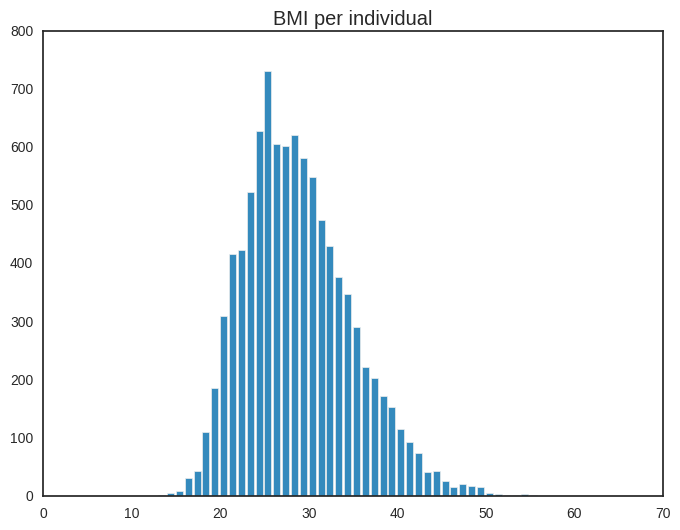

In [32]:
count = indata.groupby('BMI').BMI.count()

values = count.values
indx   = count.index

mean = sum(values)/len(indx)
variance = np.sqrt(sum((values-mean)**2)/len(indx))

plt.bar(indx, values)
plt.title('BMI per individual')
plt.xticks(rotation='horizontal')
plt.show()

In [42]:
indata.head()

,code280289,sBP,code240279,weight,code780799,code360389,height,code680709,dBP,code320359,BMI,state,code740759,code001139,code460519,code520579,code710739,code760779,code800999,code390459,diabetes,code290319,gender,age,code630679,code580629,code140239
0,0,120,1,270,0,0,69,0,80,0,41,41,0,0,0,0,0,0,0,0,0,0,1,60,0,0,1
1,0,115,1,140,1,0,64,0,60,0,24,45,0,0,1,0,1,0,0,1,0,0,0,85,0,0,0
2,0,120,1,220,1,0,68,0,70,0,33,33,0,0,0,0,1,0,1,0,0,0,1,45,0,0,0
3,0,135,1,200,0,0,72,0,80,0,27,4,0,0,1,0,0,0,0,1,0,0,1,60,0,0,0
4,0,125,1,140,1,1,62,0,80,0,25,4,0,0,0,0,1,0,1,1,0,0,0,65,0,1,0


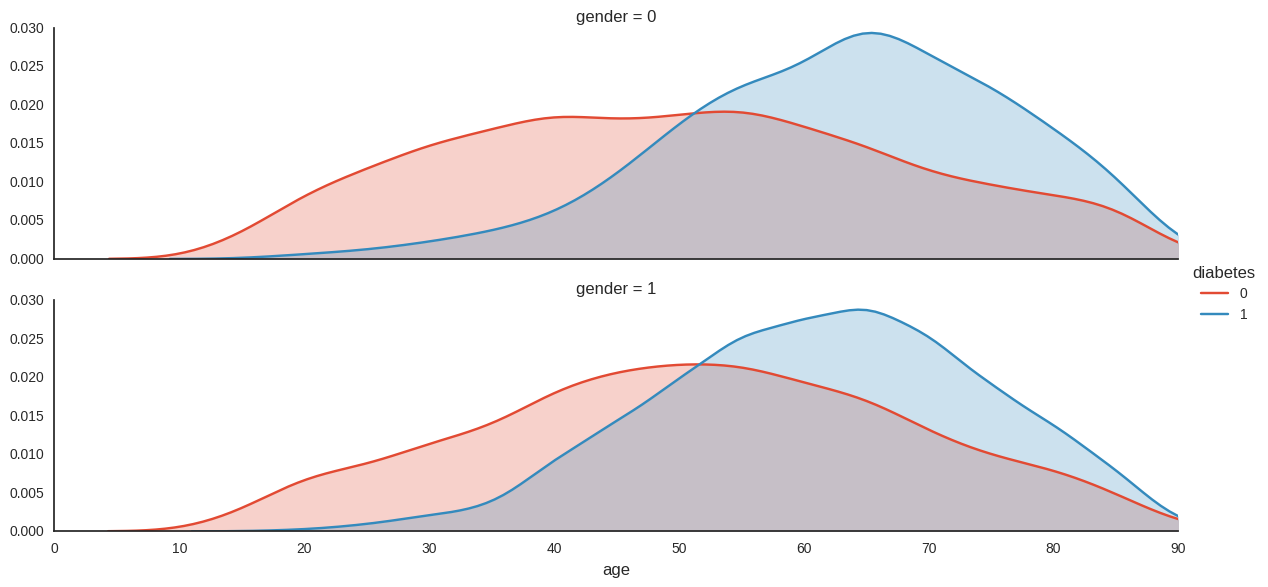

In [44]:
#distribution of males and females from different age groups with and without diabetes
plot_distribution( indata , var = 'age' , target = 'diabetes' , row = 'gender' )

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

In [126]:
X = indata.drop(["diabetes","state", "gender"],axis=1)
y = indata["diabetes"]

In [34]:
X = indata.drop(["diabetes"],axis=1)
y = indata["diabetes"]

In [63]:
X.columns

Index(['code280289', 'sBP', 'code240279', 'weight', 'code780799', 'code360389',
       'height', 'code680709', 'dBP', 'code320359', 'BMI', 'state',
       'code740759', 'code001139', 'code460519', 'code520579', 'code710739',
       'code760779', 'code800999', 'code390459', 'code290319', 'gender', 'age',
       'code630679', 'code580629', 'code140239'],
      dtype='object')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# Modeling

1. Decision Tree
    * gini
    * entropy
    * trimming
    * different break up of test vs. traning data
    * different CVs


In [52]:
#cross validation for average error metric
clf = DecisionTreeClassifier(criterion = "entropy")
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("mean error", np.mean(scores))

[ 0.75938462  0.73275862  0.74137931  0.73567468  0.74614911]
mean error 0.743069265907


In [53]:
#cross validation for average error metric
clf = DecisionTreeClassifier(criterion = "gini")
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)
print("mean error", np.mean(scores))

[ 0.74646154  0.73891626  0.71551724  0.73444239  0.73629082]
mean error 0.734325649221


In [54]:
model  = DecisionTreeClassifier(criterion = 'entropy')

In [55]:
model  = model.fit(X_train, y_train)  

In [60]:
import pydotplus as pydot
import sklearn.tree as tree
from IPython.display import Image
from sklearn.externals.six import StringIO

In [100]:
dot_data = StringIO()
f = tree.export_graphviz(model, out_file=dot_data, feature_names = X_train.columns)
graph = pydot.graph_from_dot_data(dot_data.getvalue())

In [98]:
print(type(graph))
print(type(dot_data))

<class 'pydotplus.graphviz.Dot'>
<class '_io.StringIO'>


In [94]:
import networkx as nx
from   nxpd import draw
import graphviz

In [95]:
# png = graph.create_png('png', 'dot')
# draw(graph, show='ipynb')
# print(graph.source)

AttributeError: 'Dot' object has no attribute 'source'

In [99]:
graph.write_pdf("diabetes_graph.pdf")

InvocationException: GraphViz's executables not found

In [129]:
#after trimming
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

[ 0.72738462  0.74384236  0.70935961  0.72951325  0.73998768]


In [76]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

[ 0.74704492  0.75399172  0.73979894  0.74319527  0.7295858 ]


In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Neural Net", "AdaBoost"]
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="rbf"),
    DecisionTreeClassifier(),
    MLPClassifier(),
    AdaBoostClassifier()
]

In [ ]:
from sklearn.model_selection import cross_val_score

# iterate over classifiers
results = {}
for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    results[name] = scores


In [ ]:
for name, scores in results.items():
    print("%20s | Accuracy: %0.2f%% (+/- %0.2f%%)" % (name, 100*scores.mean(), 100*scores.std() * 2))